# Logistic Regression on Amazon Fine Food Review

## Loading necessary libraries

In [8]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

## Loading already prepared corpus

In [2]:
df = pd.read_csv("../input/amazon-fine-food-corpus/corpus.csv")
df.head()

,Text,Time,Score
0,witti littl book make son laugh loud recit car...,939340800,1
1,grew read sendak book watch realli rosi movi i...,940809600,1
2,fun way children learn month year learn poem t...,944092800,1
3,great littl book read aloud nice rhythm well g...,944438400,1
4,book poetri month year goe month cute littl po...,946857600,1


## Since dataset is very large so taking out 120K points to work

In [3]:
df1k = df.loc[:119999,:]
print("Shape:- ",df1k.shape)
print(df1k.head())
df1k['Score'].value_counts()

Shape:-  (120000, 3)
                                                Text       Time  Score
0  witti littl book make son laugh loud recit car...  939340800      1
1  grew read sendak book watch realli rosi movi i...  940809600      1
2  fun way children learn month year learn poem t...  944092800      1
3  great littl book read aloud nice rhythm well g...  944438400      1
4  book poetri month year goe month cute littl po...  946857600      1


1    104604
0     15396
Name: Score, dtype: int64

## Function for time based splitting into train and test dataset

In [4]:
from sklearn.model_selection import TimeSeriesSplit
def timesplit(x,y):
    ts = TimeSeriesSplit(n_splits = 4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = timesplit(df1k["Text"].values,df1k["Score"].values)

### Feature Importance Function

In [5]:
def imp_features(model,classifier):
    voc = model.get_feature_names()
    w = list(classifier.coef_[0])
    pos_coef = []
    neg_coef = []
    pos_words = []
    neg_words = []
    for i,c in enumerate(w):
        if c > 0:
            pos_coef.append(c)
            pos_words.append(voc[i])
        if c < 0:
            neg_coef.append(abs(c))
            neg_words.append(voc[i])
    pos_df = pd.DataFrame(columns = ['Words','Coef'])
    neg_df = pd.DataFrame(columns = ['Words','Coef'])
    pos_df['Words'] = pos_words
    pos_df['Coef'] = pos_coef
    neg_df['Words'] = neg_words
    neg_df['Coef'] = neg_coef
    pos_df = pos_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    neg_df = neg_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    print("Shape of Positive dataframe:- ,",pos_df.shape)
    print("Shape of Negative dataframe:- ",neg_df.shape)
    print("Top ten positive predictors:- \n",pos_df.head(10))
    print("\nTop ten negative predictors:- \n",neg_df.head(10))

## Bag of Words Implementation

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow_train = cv.fit_transform(x_train)
print("Shape of BOW vector:- ",bow_train.shape)

Shape of BOW vector:-  (96000, 37495)


### Performing Standardization on train data

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
bow_train = sc.fit_transform(bow_train)

### Parameter tuning using GridSearchCV

In [14]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l2',solver = 'sag')
param_grid = {"C":[0.01,0.1,1,5,10,50]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'f1_micro',n_jobs = -1)
gs.fit(bow_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 1}
Best score:-  0.8738541666666667
CPU times: user 9.74 s, sys: 64 ms, total: 9.8 s
Wall time: 1min 43s


### Applying the model on test data with optimal value of C

In [15]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
bow_test = cv.transform(x_test)
bow_test = sc.transform(bow_test)   # Standardizing the test data
classifier = LogisticRegression(C=1,penalty = 'l2',solver = 'sag',n_jobs = -1)
classifier.fit(bow_train,y_train)
y_pred = classifier.predict(bow_test)
print("BOW test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred,average='micro'))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(bow_train)))

BOW test accuracy:-  0.8365833333333333
F1 score:-  0.8365833333333333
Training accuracy:-  0.8974583333333334
CPU times: user 12 s, sys: 32 ms, total: 12 s
Wall time: 12.1 s


### Confusion Matrix

Confusion Matrix:- 
 [[   61  3646]
 [  276 20017]]


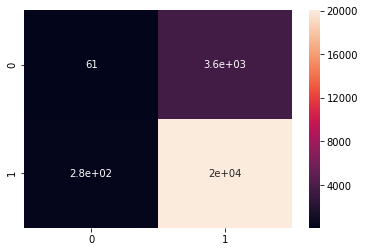

In [16]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Checking Multicollinearity using peturbation test

In [17]:
%%time
from scipy.sparse import csr_matrix
coef = classifier.coef_    #weight vector of original classifier
e = 0.02 # introducing small error in the training dataset
bow_train_pert = csr_matrix(bow_train,dtype=np.float64)
bow_train_pert[np.nonzero(bow_train_pert)]+=e
classifier_pert = LogisticRegression(C=1,penalty = 'l2',solver = 'sag',n_jobs = -1)
classifier_pert.fit(bow_train_pert,y_train)
coef_pert = classifier_pert.coef_
coef_diff = coef_pert - coef
print("Average difference in weight vectors:- ",np.mean(coef_diff))

Average difference in weight vectors:-  -4.0859155285439185e-06
CPU times: user 11.3 s, sys: 72 ms, total: 11.4 s
Wall time: 11.5 s


#### Differences in the coefficients of the peturbed model and original model are very less so weight vector of the classifier can be considered for the feature importance.

### Feature importance:- Top ten predictors from each class

In [18]:
imp_features(cv,classifier)

Shape of Positive dataframe:- , (28644, 2)
Shape of Negative dataframe:-  (8851, 2)
Top ten positive predictors:- 
      Words      Coef
0    great  0.132154
1     love  0.129421
2     good  0.099525
3     tast  0.079537
4  product  0.077945
5     best  0.075964
6   delici  0.065478
7      buy  0.060301
8     like  0.055132
9    price  0.053501

Top ten negative predictors:- 
            Words      Coef
0      superstar  0.017606
1          updat  0.016748
2           sham  0.016266
3            dis  0.016182
4      leakproof  0.016070
5  featherweight  0.015956
6           afor  0.015828
7      typograph  0.015756
8      easysweet  0.015714
9          melba  0.015650


### Error plots

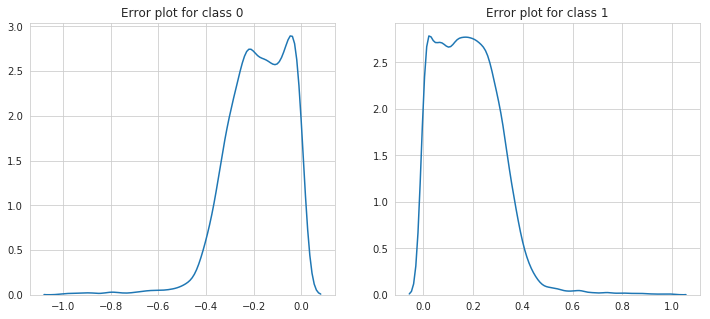

In [19]:
y_pred_prob = classifier.predict_proba(bow_test)
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred_prob[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred_prob[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

### =====================================================================================

### Tfidf implementation

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True)
tfidf_train = tfidf.fit_transform(x_train)
print("Shape of tfidf_train:- ",tfidf_train.shape)

Shape of tfidf_train:-  (96000, 37495)


### Standardizing the data

In [66]:
sc = StandardScaler(with_mean = False)
tfidf_train = sc.fit_transform(tfidf_train)

### Parameter tuning using GridSearchCV

In [25]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l1',solver = 'liblinear',class_weight = 'balanced')
param_grid = {"C":[0.01,0.1,1,10,50]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'f1',n_jobs = -1)
gs.fit(tfidf_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 0.01}
Best score:-  0.793165238992507
CPU times: user 2.83 s, sys: 196 ms, total: 3.02 s
Wall time: 5min 11s


### Testing the model on test data with optimal C.

In [27]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
tfidf_test = tfidf.transform(x_test)
tfidf_test = sc.transform(tfidf_test)   # Standardizing the test data
classifier = LogisticRegression(C=0.01,penalty = 'l1',solver = 'liblinear',class_weight = 'balanced')
classifier.fit(tfidf_train,y_train)
y_pred = classifier.predict(tfidf_test)
print("Tfdif test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(tfidf_train)))

Tfdif test accuracy:-  0.65575
F1 score:-  0.7812781278127813
Training accuracy:-  0.7824270833333333
CPU times: user 3.74 s, sys: 36 ms, total: 3.78 s
Wall time: 3.78 s


### Testing the model with class_weight as None

In [67]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
tfidf_test = tfidf.transform(x_test)
tfidf_test = sc.transform(tfidf_test)   # Standardizing the test data
classifier = LogisticRegression(C=0.01,penalty = 'l1',solver = 'liblinear')
classifier.fit(tfidf_train,y_train)
y_pred = classifier.predict(tfidf_test)
print("Tfdif test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(tfidf_train)))

Tfdif test accuracy:-  0.8383333333333334
F1 score:-  0.9118942731277533
Training accuracy:-  0.8979479166666666
CPU times: user 2.19 s, sys: 44 ms, total: 2.23 s
Wall time: 2.24 s


### Confusion Matrix of model with class_weight as None

Confusion Matrix:- 
 [[   45  3662]
 [  213 20080]]


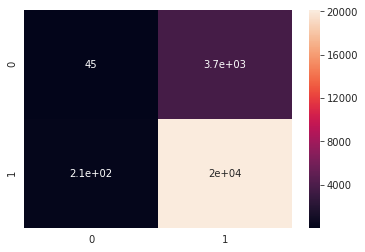

In [60]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Confusion Matrix of model with class_weight='balanced'

Confusion Matrix:- 
 [[  982  2725]
 [ 5537 14756]]


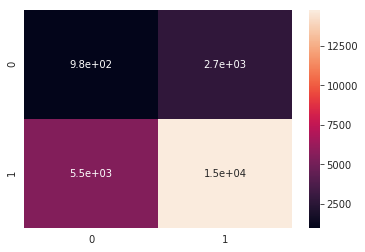

In [28]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Feature Importance:- Top ten predictors of each class

In [29]:
print("No. of features with zero coefficients:- ",tfidf_train.shape[1]-np.count_nonzero(classifier.coef_))
imp_features(tfidf,classifier)

No. of features with zero coefficients:-  24173
Shape of Positive dataframe:- , (7167, 2)
Shape of Negative dataframe:-  (6155, 2)
Top ten positive predictors:- 
         Words      Coef
0      sticki  0.061752
1     lifetim  0.054031
2     meantim  0.048732
3       froth  0.048396
4         www  0.046683
5       wasnt  0.046515
6  competitor  0.046206
7       curri  0.045884
8        asid  0.045820
9       laxat  0.045722

Top ten negative predictors:- 
        Words      Coef
0     durabl  0.035768
1      laugh  0.032124
2      melba  0.031048
3  cranberri  0.029276
4      puppi  0.028483
5       bold  0.028328
6       sham  0.028226
7       theo  0.027747
8      heavi  0.027099
9       nice  0.027000


### Error Plots of model with class_weight as 'balanced'

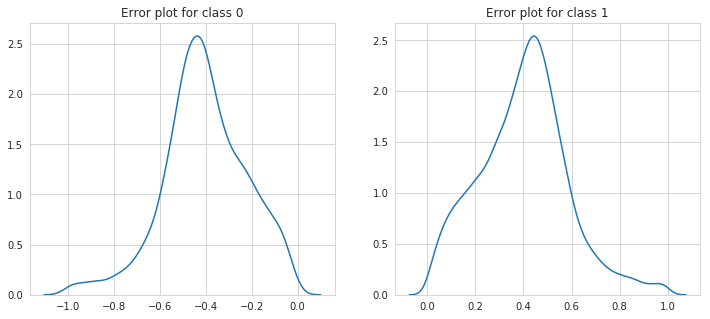

In [31]:
y_pred_prob = classifier.predict_proba(tfidf_test)
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred_prob[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred_prob[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

### Error plot of model with class_weight as None

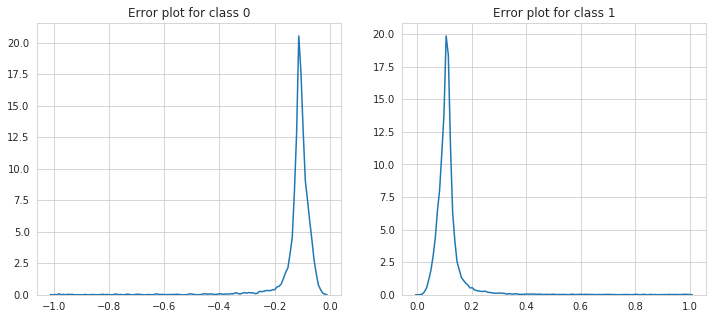

In [68]:
y_pred_prob = classifier.predict_proba(tfidf_test)
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred_prob[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred_prob[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

### =====================================================================================

### Word2Vec

In [33]:
#Function to create list of sentences
def sent_list(x):
    list_of_sent = []
    for sent in tqdm(x):
        words = []
        for w in sent.split():
            words.append(w)
        list_of_sent.append(words)
    return list_of_sent

In [34]:
#implementing word2vec
from gensim.models import Word2Vec
sent_train = sent_list(x_train)
w2v = Word2Vec(sent_train,size=50,min_count=2,workers=4)

100%|██████████| 96000/96000 [00:00<00:00, 97094.80it/s]


### Average Word2Vec implementation:-

In [35]:
#Function to create avg word2vec vector
def avgw2v(x):
    avgw2v_vec = []
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        count = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                sent_vec+=vec
                count+=1
            except:
                pass
        sent_vec/=count
        avgw2v_vec.append(sent_vec)
    return avgw2v_vec

In [61]:
#Creating average word2vec training data
avgw2v_train = np.array(avgw2v(sent_train))
print("Shape of avg word2vec train data:- ",avgw2v_train.shape)

100%|██████████| 96000/96000 [00:13<00:00, 7340.78it/s]


Shape of avg word2vec train data:-  (96000, 50)


#### Standardizing the data

In [62]:
sc = StandardScaler()
avgw2v_train = sc.fit_transform(avgw2v_train)

#### Applying GridSearchCV to find optimal hyperparameter

In [40]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l2',solver='sag',class_weight = 'balanced')
param_grid = {"C":[0.01,0.1,1,10,50]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'f1',n_jobs = -1)
gs.fit(avgw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 1}
Best score:-  0.6027169428662572
CPU times: user 3.47 s, sys: 72 ms, total: 3.54 s
Wall time: 28.9 s


#### Testing the model on the test data 

In [41]:
%%time
sent_test = sent_list(x_test)
avgw2v_test = np.array(avgw2v(sent_test))
avgw2v_test = sc.transform(avgw2v_test)
classifier = LogisticRegression(C=1,penalty = 'l2',solver = 'sag',class_weight = 'balanced')
classifier.fit(avgw2v_train,y_train)
y_pred = classifier.predict(avgw2v_test)
print("Avg Word2Vec test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(avgw2v_train)))

100%|██████████| 24000/24000 [00:03<00:00, 6927.40it/s]


Avg Word2Vec test accuracy:-  0.5000416666666667
F1 score:-  0.6282261812548412
Training accuracy:-  0.5098854166666666
CPU times: user 7.44 s, sys: 164 ms, total: 7.61 s
Wall time: 7.5 s


### Testing the model with class_weight as None

In [63]:
%%time
sent_test = sent_list(x_test)
avgw2v_test = np.array(avgw2v(sent_test))
avgw2v_test = sc.transform(avgw2v_test)
classifier = LogisticRegression(C=1,penalty = 'l2',solver = 'sag')
classifier.fit(avgw2v_train,y_train)
y_pred = classifier.predict(avgw2v_test)
print("Avg Word2Vec test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(avgw2v_train)))

100%|██████████| 24000/24000 [00:03<00:00, 7262.89it/s]


Avg Word2Vec test accuracy:-  0.8455416666666666
F1 score:-  0.916307317183302
Training accuracy:-  0.8782395833333333
CPU times: user 6.29 s, sys: 116 ms, total: 6.4 s
Wall time: 6.29 s


### Confusion matrix of model with class_weight as None

Confusion Matrix:- 
 [[    0  3707]
 [    0 20293]]


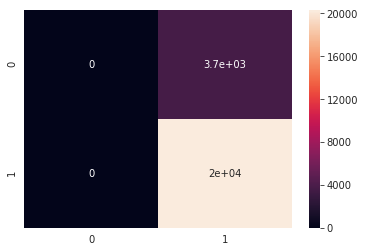

In [64]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

#### Confusion Matrix of model with class_weight as 'balanced'.

Confusion Matrix:- 
 [[ 1863  1844]
 [10155 10138]]


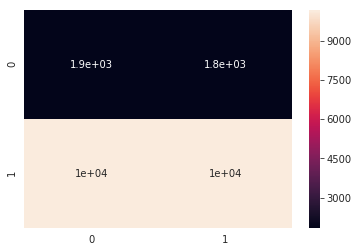

In [42]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

#### Error Plots:-

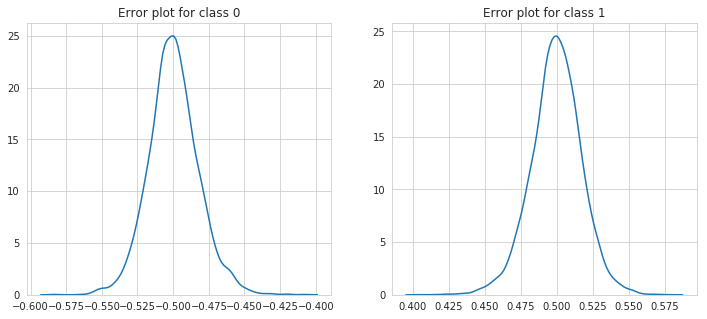

In [43]:
y_pred_prob = classifier.predict_proba(avgw2v_test)
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred_prob[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred_prob[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

### ==================================================================================

### Tfidf Word2Vec implementation

In [44]:
#Function for creating tfidf weighted Word2Vec
def tfidfw2v(x):
    dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
    tfidf_w2v_vec = []
    i=0
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        weights = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                tfidf_value = dictionary[word]*sent.count(word)
                sent_vec+=(tfidf_value*vec)
                weights+=tfidf_value
            except:
                pass
        sent_vec/=weights
        tfidf_w2v_vec.append(sent_vec)
        i+=1
    return tfidf_w2v_vec

In [45]:
tfidfw2v_train = np.array(tfidfw2v(sent_train))
print("Shape of tfidf avgw2v train vector:- ",tfidfw2v_train.shape)

100%|██████████| 96000/96000 [00:34<00:00, 2788.47it/s]


Shape of tfidf avgw2v train vector:-  (96000, 50)


#### Standardizing the data

In [46]:
sc = StandardScaler()
tfidfw2v_train = sc.fit_transform(tfidfw2v_train)

#### Applying GridSearchCV to find optimal hyperparameter

In [48]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty = 'l2',solver='sag',class_weight = 'balanced')
param_grid = {"C":[0.1,1,10,50,100]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'f1',n_jobs = -1)
gs.fit(tfidfw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 10}
Best score:-  0.5914317424299339
CPU times: user 3.88 s, sys: 56 ms, total: 3.93 s
Wall time: 35.6 s


#### Applying model on test data with optimal hyperparameter

In [53]:
%%time
sent_test = sent_list(x_test)
tfidfw2v_test = np.array(tfidfw2v(sent_test))
tfidfw2v_test = sc.transform(tfidfw2v_test)
classifier = LogisticRegression(C=10,penalty = 'l2',solver = 'sag',class_weight = 'balanced')
classifier.fit(tfidfw2v_train,y_train)
y_pred = classifier.predict(tfidfw2v_test)
print("Tfidf Word2Vec test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(tfidfw2v_train)))

100%|██████████| 24000/24000 [00:08<00:00, 2826.58it/s]


Tfidf Word2Vec test accuracy:-  0.49795833333333334
F1 score:-  0.6254934261647966
Training accuracy:-  0.5072916666666667
CPU times: user 13.1 s, sys: 1.43 s, total: 14.6 s
Wall time: 12.8 s


#### Confusion Matrix

Confusion Matrix:- 
 [[ 1889  1818]
 [10231 10062]]


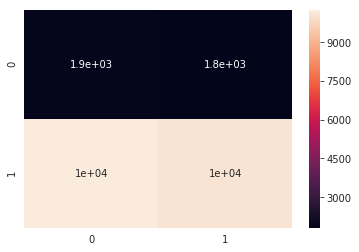

In [54]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Error Plots:-

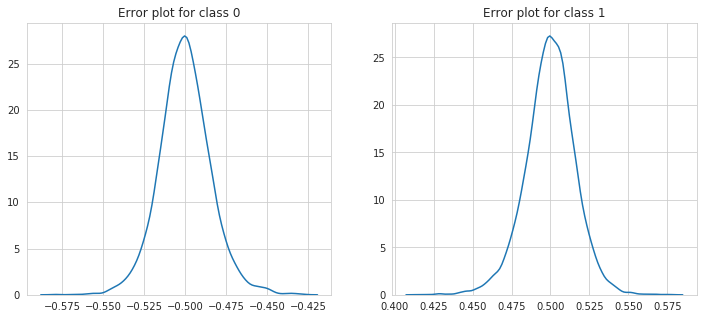

In [55]:
y_pred_prob = classifier.predict_proba(tfidfw2v_test)
sns.set_style("whitegrid")
plt.figure(1,figsize = (12,5))
plt.subplot(121)
delta0 = y_test[y_test == 0] - y_pred_prob[y_test==0,0]
sns.kdeplot(np.array(delta0))
plt.title("Error plot for class 0")
plt.subplot(122)
delta1 = y_test[y_test == 1] - y_pred_prob[y_test==1,1]
sns.kdeplot(np.array(delta1))
plt.title("Error plot for class 1")
plt.show()

### ===================================================================================

## Results:-

| Model | Hyperparameter(C) | Training Accuracy | Test Accuracy |
| - | - | - | - |
| Bag of Words | 1 | 89.7 | 83.6 |
|Tfidf | 0.01 | 78, 89.7 | 65.57, 83.8 |
| Avg Word2Vec | 1 | 50.98, 87.8 | 50, 84.5 |
| Tfidf Word2Vec | 10 | 50.72 | 49.79 |

### Conclusion:-
#### Losgistic Regression has given overall good results with Bag of Words and Tfidf vectors.

#### Logisitic Regression is not at all performing good when applying on Word2Vec vectors. When i am not using class_weight='balanced' it is classifying all points as postive and when i am using class_weight='balanced' it is giving very less accuracy.

### ===================================================================================